In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [38]:
import os, sys
sys.path.append('..')
from glob import glob
from configs import *
from tqdm import tqdm
from utils import *
import numpy as np
import matplotlib.pyplot as plt
from dataset import *
from time import time
tqdm.monitor_interval = 0
import torch
import json
import torch.nn as nn
import numpy as np
from graphviz import Digraph, Graph
from forecast import *
from mpl_toolkits.mplot3d import Axes3D
torch.manual_seed(0)
torch.cuda.manual_seed(0)
np.random.seed(0)

In [3]:
with open('../data/man.json') as fl:
    mvs, madj = json.load(fl)

In [4]:
len(mvs)

684

In [30]:
partitions = []

cvs, cadj = complete_graph(mvs, madj)

touched = {}
for vert in cvs:
    if vert in touched:
        continue
        
    queue = [vert]
    visited = {}
    while len(queue):
        head = queue.pop(0)
#         print(len(queue))
        visited[head] = True
        touched[head] = True
        for child in cadj[head]:
            if child not in visited:
                queue.append(child)
#     print(len(visited))

    partitions.append(list(visited.keys()))

In [33]:
partitions = sorted(partitions, key=lambda ls: len(ls))[::-1]
for part in partitions:
    print(len(part))

156
137
100
52
48
39
39
19
16
15
14
12
10
9
5
4
4
3
2


In [157]:
import pydot
def simple_graph(tag, vs, adj):
    mang = Digraph(format='jpg', engine='dot', 
                 graph_attr={
                     'splines':"ortho",
                     'nodesep':'1',
#                      'nodesep': '.2',
                     'rankdir':'LR',
                     'fixedsize':'true',
                     'width':'1',
                     'height': '1',
#                      'ranksep': '.2'
                 })
    imap = {}
    for vi, vert in enumerate(vs):
        imap[vert] = str(vi)
        mang.node(str(vi), '',width='0.5', height='0.5')
    for vi, (vert, alist) in enumerate(adj.items()):
        for dest in alist:
            mang.edge(imap[vert], imap[dest], rank='same')

    mang.render(tag)
    
    plt.figure(figsize=(14, 10))
    plt.imshow(cv2.cvtColor(cv2.imread('%s.jpg' % tag), cv2.COLOR_BGR2RGB))
    plt.show(); plt.close()
    
force_edges = [
    [(3, 49)],
    None,
    None,
]
sfull = []
for pi, pvs in enumerate(partitions):
    if len(pvs) < 50:
        break
    
    svs, sadj = subgraph(pvs, mvs, madj)
#     simple_graph(svs, sadj)
    for vert in svs:
        sfull.append(vert)
    print(len(pvs))

156
137
100
52


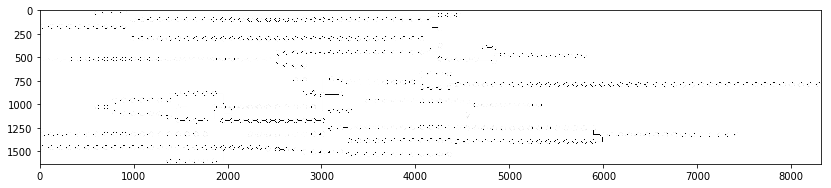

In [158]:
fvs, fadj = subgraph(sfull, mvs, madj)
simple_graph('full', fvs, fadj)

In [159]:
gmap = {}
for gi, gfile in enumerate(glob('../data/graphs/*_n5.json')):
#     print(gfile)
    with open(gfile) as fl:
        svs, _  = json.load(fl)
    for vert in svs:
        gmap[vert] = gi
print(len(gmap))

532


### Full Graph (with subgroups)

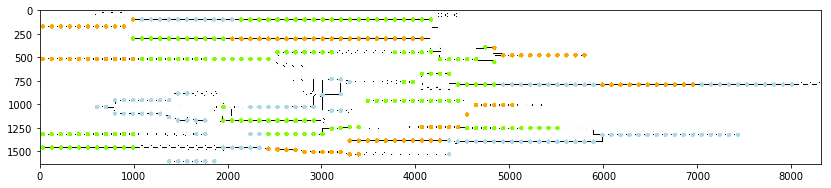

In [160]:
mang = Digraph(format='jpg', engine='dot', graph_attr={
    'splines':"ortho",
    'nodesep':'1',
    'rankdir':'LR',
    'fixedsize':'true',
})
imap = {}

for vi, vert in enumerate(fvs):
    imap[vert] = str(vi)
    if vert in gmap:
        clr = ['orange', 'chartreuse', 'lightblue'][gmap[vert] % 3]
        fclr = clr
    else:
#         clr = None
        fclr = 'white'
        clr = 'black'
    mang.node(str(vi), '',width='0.5', height='0.5', fillcolor=fclr, color=clr, style='filled')
for vi, (vert, alist) in enumerate(fadj.items()):
    for dest in alist:
        mang.edge(imap[vert], imap[dest], rank='same', penwidth='2')

mang.render('full')
plt.figure(figsize=(14, 10))
plt.imshow(cv2.cvtColor(cv2.imread('full.jpg'), cv2.COLOR_BGR2RGB))
plt.show(); plt.close()

### Curriculum progression

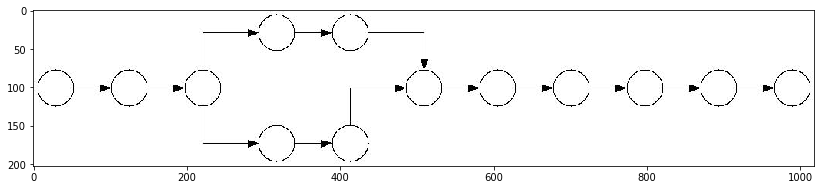

In [127]:
with open('../data/graphs/400108-400109_n5.json') as fl:
    svs, sadj  = json.load(fl)

simple_graph('temp', svs, sadj)

(1019, 2015, 3)


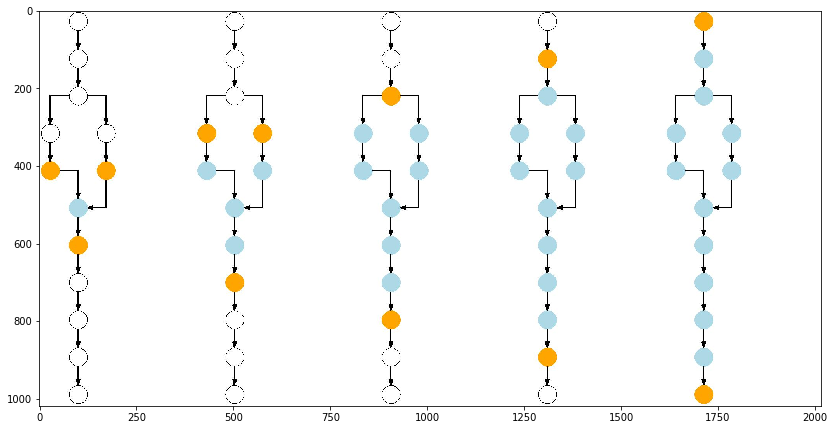

In [156]:
dmap = {svs[0]:0} # depth from root
queue = [svs[0]]
visited = {}
while len(queue):
    head = queue.pop(0)
    visited[head] = True
    for child in sadj[head]:
        if child not in visited:
            queue.append(child)
            dmap[child] = dmap[head] + 1
rvs, radj = reverse_graph(svs, sadj)
visited = {}
queue = [svs[0]]
while len(queue):
    head = queue.pop(0)
    visited[head] = True
    for child in radj[head]:
        if child not in visited:
            queue.append(child)
            dmap[child] = dmap[head] + 1
assert len(dmap) == len(svs)

stacked = []
for hops in range(1, 6):
    mang = Digraph(format='jpg', engine='dot', 
                 graph_attr={
                     'splines':"ortho",
                     'nodesep':'1',
#                      'nodesep': '.2',
#                      'rankdir':'LR',
                     'fixedsize':'true',
                     'width':'1',
                     'height': '1',
#                      'ranksep': '.2'
                 })
    imap = {}
    for vi, vert in enumerate(svs):
        vname = '%d_%d' % (hops, vi)
        imap[vert] = vname
        if dmap[vert] <= hops-1:
            fcl = 'lightblue'
            clr = 'lightblue'
        elif dmap[vert] <= hops:
            fcl = 'orange'
            clr = 'orange'
        else:
            fcl = 'white'
            clr = 'black'
        mang.node(vname, '',width='0.5', height='0.5', style='filled', fillcolor=fcl, color=clr)
        
    for vi, (vert, alist) in enumerate(sadj.items()):
        for dest in alist:
            mang.edge(imap[vert], imap[dest], penwidth='2')
        
    mang.render('prog')
    img = cv2.cvtColor(cv2.imread('prog.jpg'), cv2.COLOR_BGR2RGB)
#     print(img.shape)
    pad = 255 * np.ones((img.shape[0], 200, img.shape[2]), dtype=int)
    stacked.append(img)
    stacked.append(pad)

stacked = np.hstack(stacked)
print(stacked.shape)
cv2.imwrite('prog.jpg', cv2.cvtColor(stacked.astype(np.uint8), cv2.COLOR_BGR2RGB))
plt.figure(figsize=(14, 10))
plt.imshow(stacked)
plt.show(); plt.close()